In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import utils.signals.gps_l1ca as gps_l1ca
import utils

In [7]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)
raw_collects_dir = os.path.join(data_dir, "raw-collects")
os.makedirs(raw_collects_dir, exist_ok=True)
raw_collect_filenames = sorted(os.listdir(raw_collects_dir))
print(f"Data directory: {data_dir}")
print(f"Files in raw-collects directory: {raw_collect_filenames}")
filepath = os.path.join(raw_collects_dir, raw_collect_filenames[0])
print(f"Using data file: {filepath}")

Data directory: /home/brianbw/projects/fall-2025-lectures/local-data
Files in raw-collects directory: ['g072602f.dat']
Using data file: /home/brianbw/projects/fall-2025-lectures/local-data/raw-collects/g072602f.dat


In [27]:
samples = np.fromfile(filepath, dtype=np.int32)

In [28]:
samp_rate = 5e6
samples.size / samp_rate

0.262144

Text(0.5, 0, 'Sample Value')

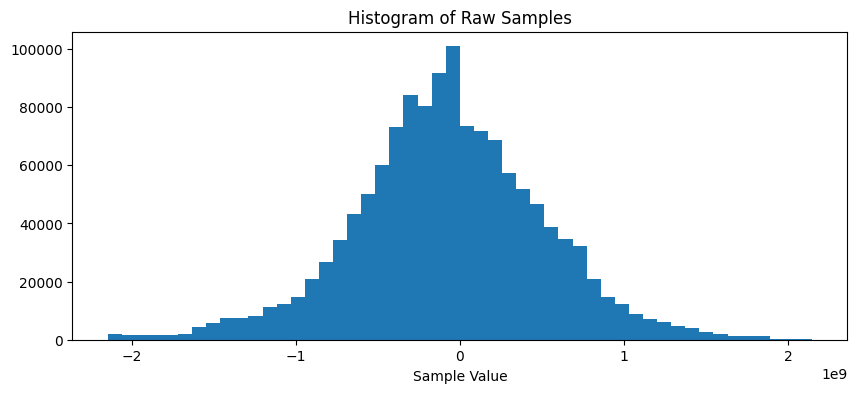

In [29]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(samples, bins=50)
ax.set_title("Histogram of Raw Samples")
ax.set_xlabel("Sample Value")